마스크 데이터셋을 읽고 전처리를 진행한 후 데이터를 하나씩 꺼내주는 Dataset 클래스를 구현한 파일입니다.

이 곳에서, 나만의 Data Augmentation 기법 들을 구현하여 사용할 수 있습니다.

In [47]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
from PIL import Image

In [5]:
get_data = pd.read_csv(r'/opt/ml/data/train/train.csv')
get_data = get_data.drop(['race','id'],axis=1)
get_data

,gender,age,path
0,female,45,000001_female_Asian_45
1,female,52,000002_female_Asian_52
2,male,54,000004_male_Asian_54
3,female,58,000005_female_Asian_58
4,female,59,000006_female_Asian_59
...,...,...,...
2695,male,19,006954_male_Asian_19
2696,male,19,006955_male_Asian_19
2697,male,19,006956_male_Asian_19
2698,male,20,006957_male_Asian_20


In [6]:
get_data.values

array([['female', 45, '000001_female_Asian_45'],
       ['female', 52, '000002_female_Asian_52'],
       ['male', 54, '000004_male_Asian_54'],
       ...,
       ['male', 19, '006956_male_Asian_19'],
       ['male', 20, '006957_male_Asian_20'],
       ['male', 19, '006959_male_Asian_19']], dtype=object)

In [12]:
DIR_ROOT = r'/opt/ml/data/train/images/'
target = get_data.values
image_locate = [DIR_ROOT + i for i in get_data['path']]
images = []
for i in image_locate:
    temp = []
    for j in os.listdir(i):
        if not j[0] == '.':
            temp.append(i+'/'+j)
    images.append(temp)
images[:2]


[['/opt/ml/data/train/images/000001_female_Asian_45/mask3.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask4.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask1.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask5.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/mask2.jpg',
  '/opt/ml/data/train/images/000001_female_Asian_45/normal.jpg'],
 ['/opt/ml/data/train/images/000002_female_Asian_52/mask3.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask4.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask1.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask5.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/mask2.jpg',
  '/opt/ml/data/train/images/000002_female_Asian_52/normal.jpg']]

In [28]:
label_data = []
file_name_string = 'min'
labeled_dict = {"label": [],
                "gender": [],
                "age": [],
                "locate": []}
for i in images:
    for j in i:
        #/opt/ml/data/train/images/000002_female_Asian_52/normal.jpg 자른 것
        get_locate_file = j.split('/')
        #가장 끝의 파일은 이미지 이름이다.
        label = file_name_string.index(get_locate_file[-1][0])
        start = label * 6
        #000002_female_Asian_52 잘라서 굳이 위에 선언한 데이터 불러오지 않고 수행
        _, sex, _, age = get_locate_file[-2].split('_')
        age = int(age)
        if sex == 'female':
            start +=3
        if age < 30:
            pass
        elif age < 60:
            start +=1
        else:
            start +=2
        labeled_dict['label'].append(start)
        labeled_dict['gender'].append(sex)
        labeled_dict['age'].append(age)
        labeled_dict['locate'].append(j)

labeled_dict = pd.DataFrame(labeled_dict, columns=labeled_dict.keys())
labeled_dict

,label,gender,age,locate
0,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
1,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
2,10,female,45,/opt/ml/data/train/images/000001_female_Asian_...
3,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
4,4,female,45,/opt/ml/data/train/images/000001_female_Asian_...
...,...,...,...,...
18895,6,male,19,/opt/ml/data/train/images/006959_male_Asian_19...
18896,0,male,19,/opt/ml/data/train/images/006959_male_Asian_19...
18897,0,male,19,/opt/ml/data/train/images/006959_male_Asian_19...
18898,0,male,19,/opt/ml/data/train/images/006959_male_Asian_19...


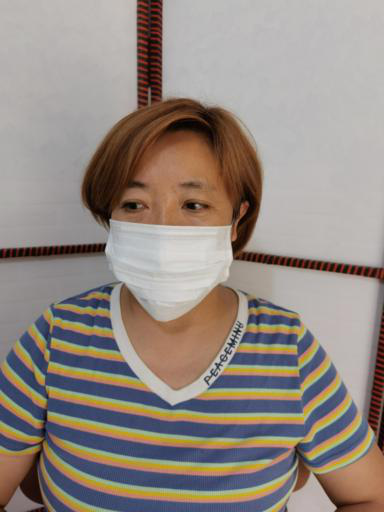

In [46]:
class MaskDataset(Dataset):
    def __init__(self, data, transform= None):
        self.data = data
        self.classes = ['label', 'gender', 'age', 'locate']
        self.transform = transform

    def __len__(self):
        return (len(self.data))

    def __getitem__(self, idx):
        X = Image.open(self.data['locate'].iloc[idx])
        y = self.data['label'].iloc[idx]
        if self.transform is not None:
            X = self.transform(X)

        return X,y

datasets = MaskDataset(labeled_dict, 
transforms.Compose([
    # 선형 보간법을 사용하여 출력 픽셀값을 계산 -> 부드러운 느낌을 준다는데 누구 기준인진 잘
    transforms.Resize((512,384), Image.BILINEAR),
    transforms.ToTensor(),
    ])
)
img,lb = datasets[0]
im_pil = transforms.ToPILImage()(img)
im_pil


In [54]:
data_loader = DataLoader(datasets, batch_size=32, shuffle=True, num_workers=2)
next(iter(data_loader))

[tensor([[[[0.3294, 0.3333, 0.3412,  ..., 0.3608, 0.3529, 0.3490],
           [0.3294, 0.3333, 0.3412,  ..., 0.3608, 0.3569, 0.3529],
           [0.3333, 0.3333, 0.3373,  ..., 0.3647, 0.3608, 0.3608],
           ...,
           [0.1765, 0.1804, 0.1804,  ..., 0.0510, 0.0549, 0.0510],
           [0.1843, 0.1843, 0.1765,  ..., 0.0431, 0.0510, 0.0510],
           [0.1961, 0.1922, 0.1765,  ..., 0.0392, 0.0431, 0.0471]],
 
          [[0.4980, 0.5020, 0.5098,  ..., 0.5333, 0.5255, 0.5216],
           [0.4980, 0.5020, 0.5098,  ..., 0.5333, 0.5294, 0.5255],
           [0.5020, 0.5020, 0.5059,  ..., 0.5373, 0.5333, 0.5333],
           ...,
           [0.1843, 0.1882, 0.1882,  ..., 0.1098, 0.1216, 0.1294],
           [0.1922, 0.1922, 0.1843,  ..., 0.1020, 0.1176, 0.1176],
           [0.2039, 0.2000, 0.1843,  ..., 0.0980, 0.1098, 0.1137]],
 
          [[0.4235, 0.4275, 0.4353,  ..., 0.4745, 0.4667, 0.4627],
           [0.4235, 0.4275, 0.4353,  ..., 0.4745, 0.4706, 0.4667],
           [0.4275, 0.42